In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'D:\\Analysis_Cache'
beh_directory = 'P:\\Behavioor'

%run animal_info
ANIMAL = 'AC_12102016'

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

# Load Results from Mouse Stimulus Data

In [3]:
#filename = 'D:\\MouseDataStimulusDecodingCached.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached4858units2022-09-23.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5632units2022-10-05.csv'
#filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv'
filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-20FromCache.csv'

#filename = 'D:\\MouseDatastimulusDecodingCached5759units2022-10-07.csv'#eLife Criterion

mouse_df = pd.read_csv (filename)

sessionIDs = mouse_df['sessions']
clusters = mouse_df['clusters']
accuracies = mouse_df['accuracies']
accuracies_std = mouse_df['accuracies_std']
accuracies_sem = mouse_df['accuracies_sem']
waccuracies = mouse_df['waccuracies']
waccuracies_std = mouse_df['waccuracies_std']
waccuracies_sem = mouse_df['waccuracies_sem']
caccuracies = mouse_df['caccuracies']
#caccuracies_std = mouse_df['caccuracies_std']
caccuracies_sem = mouse_df['caccuracies_sem']
pvals = mouse_df['pvals']

categories = 'stimulus'

# Generate Regions

In [4]:
regions = ['NA']*len(sessionIDs)
for idx,sessionID in tqdm(enumerate(sessionIDs)):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    regions[idx] = sessionfile.meta.region

5801it [00:41, 141.08it/s]


# Generate FRmods

In [5]:
FRmods = np.full(len(sessionIDs),np.nan)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    FRmods[idx] = sessionfile.responsiveness[clust]['all_trials'].FRmodulationchoice
    
colors = NCR_CR_cmap(FRmods/4)

5801it [00:41, 138.70it/s]


# Calculate Task Encoder Cutoff

In [12]:
low_decoders = np.less(accuracies,0.5)
low_accuracies = accuracies[low_decoders]
low_magnitudes = np.absolute(low_accuracies-0.5)

low_magnitudes = np.sort(low_magnitudes)
task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
print('Task encoder threshold: '+str(task_encoder_threshold))

Task encoder threshold: 0.5643597560975608


In [13]:
task_encoders = np.greater(accuracies,task_encoder_threshold)
task_encoders = np.logical_and(task_encoders,np.less_equal(pvals,0.05))
task_encoders = np.logical_and(task_encoders,np.isfinite(pvals))

In [14]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 398/398 [00:02<00:00, 173.15it/s]

[]


# Generate Learning Phases (from curves)

In [7]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
#animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

BS_40
BS_41
BS_42
BS_49
BS_50
BS_51
BS_56
BS_59
BS_67
BS_70
BS_72
BS_87
BS_108
DS_15
DS_19


AttributeError: 'NoneType' object has no attribute 'dpi_scale_trans'

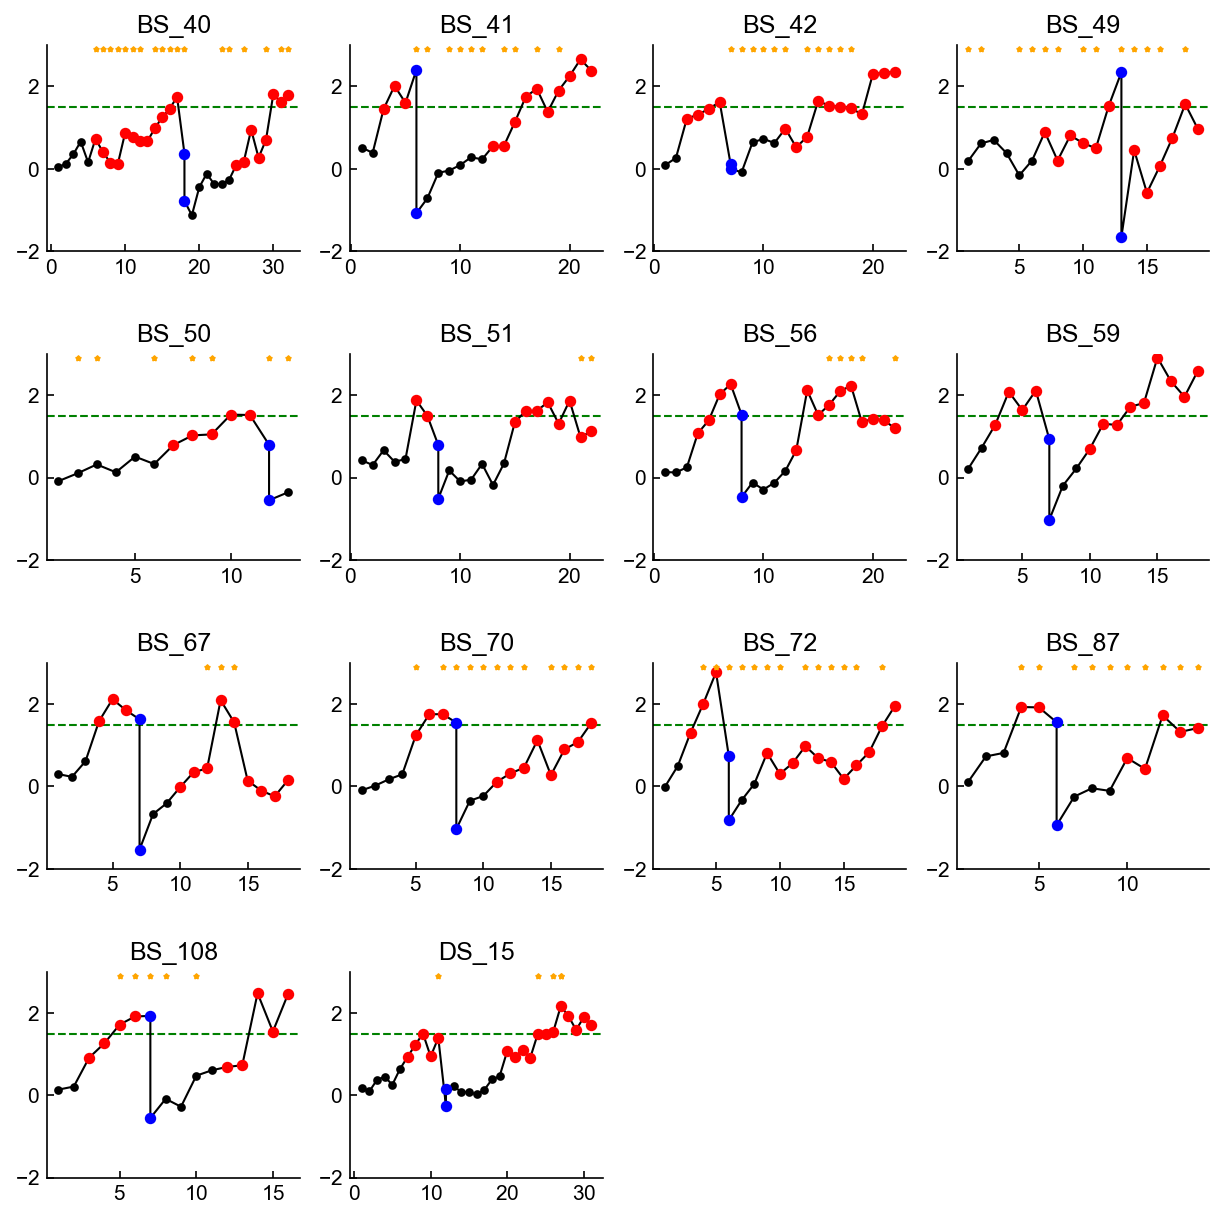

In [8]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    plt.delaxes(axs[14])
    plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal:
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[maxreversaldp])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    maxperf = np.nanmax(postreversaldps)
    minperf = np.nanmin(np.concatenate((postreversaldps,[minreversaldp])))
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday),np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [10]:
EILphases = ['ERROR']*len(sessionIDs)
for idx,(sessionID,clust) in tqdm(enumerate(zip(sessionIDs,clusters))):
    sessionfile = ilep.loadSessionCached(act_directory,sessionID)
    
    EILphase = 'ERROR'
    try:
        if sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre early'
        elif sessionfile.meta.condition == 'prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'pre int'
        elif sessionfile.meta.condition == 'prereversal expert':
            EILphase = 'pre late'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post early'
        elif sessionfile.meta.condition == 'postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphase = 'post int'
        elif sessionfile.meta.condition == 'postreversal expert':
            EILphase = 'post late'
        elif sessionfile.meta.condition == 'reversal':
            EILphase = 'switch'
    except:
        EILphase = 'ERROR'
    
    EILphases[idx] = EILphase

5801it [00:41, 138.35it/s]


# Generate Three Day Slope Learning Phases (from curves)

BS_40
BS_41
BS_42
BS_49
BS_50


TypeError: slice indices must be integers or None or have an __index__ method

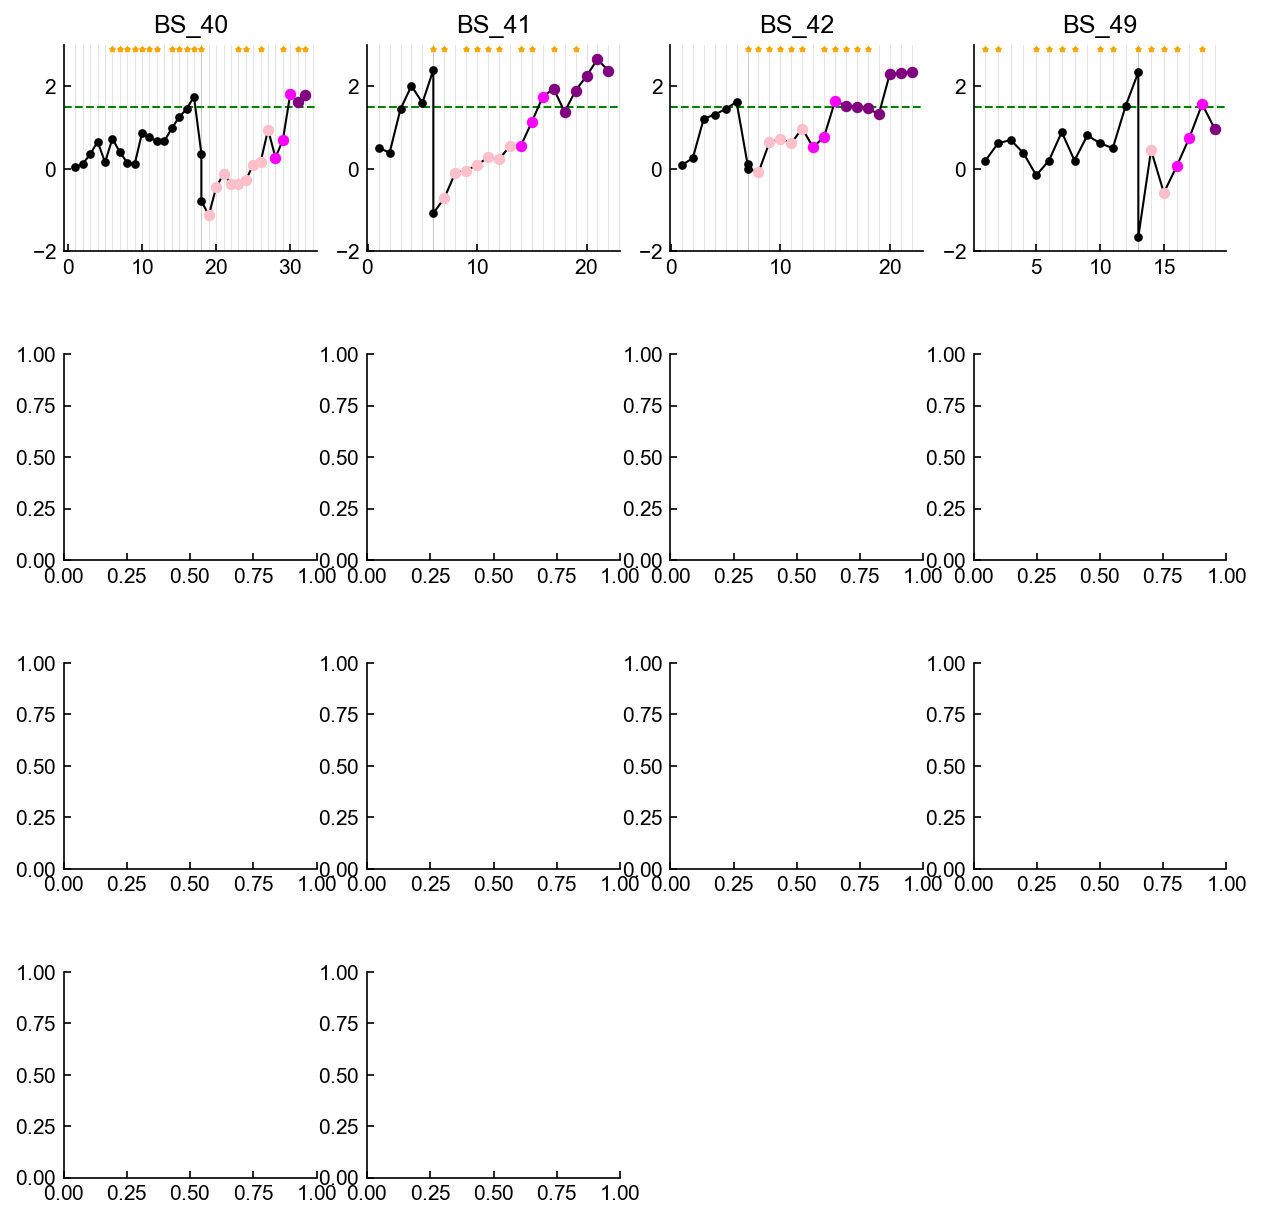

In [11]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMT.csv')
#filename = os.path.join('C:\\\\Users','4thgr','Desktop','DataForJMT.csv')
csv = pd.read_csv(filename)

plot=True
if plot:
    fig = plt.figure(figsize=(10,10))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    plt.delaxes(axs[14])
    plt.delaxes(axs[15])

threeDayPhases = dict()

for animalidx,animal in enumerate(animals):
    threeDayPhases[animal] = SimpleNamespace()
    print(animal)
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
    days = np.array(days,dtype=int)
    
    #Make relative to reversal
    #days = days - animals[animal].reversal
    
    max_three_day_slope = -np.Inf
    max_slope_idx = np.nan
    for idx,day in enumerate(days):
        #Skip prereversal and switch days
        if day <= animals[animal].reversal:
            continue
        #Cut off before running over the end
        if idx+2 >= len(days):
            break
            
        slope = cond[idx+2] - cond[idx]
        
        if slope >= max_three_day_slope:
            max_three_day_slope = slope
            max_slope_idx = idx
    
    #Save out results
    days_involved = days[max_slope_idx:(max_slope_idx+3)]
    
    threeDayPhases[animal].maxSlope = days_involved
    threeDayPhases[animal].preSlope = days[animals[animal].reversal : days_involved[0]]#days_involved - 3
    threeDayPhases[animal].postSlope = days[days_involved[2]+1 : len(days)-1]#days_involved + 3
    
    threeDayPhases[animal].preSlope = threeDayPhases[animal].preSlope[    np.greater(threeDayPhases[animal].preSlope    ,    animals[animal].reversal)    ]
    maxDay = np.max(days)
    threeDayPhases[animal].postSlope = threeDayPhases[animal].postSlope[    np.less_equal(threeDayPhases[animal].postSlope    ,    maxDay)    ]
    
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        
        days_involved = days[max_slope_idx:(max_slope_idx+3)]
        conds_involved = cond[max_slope_idx:(max_slope_idx+3)]
        
        ax.scatter(days[threeDayPhases[animal].maxSlope],cond[threeDayPhases[animal].maxSlope],color='magenta',s=20,zorder=10)
        ax.scatter(days[threeDayPhases[animal].preSlope],cond[threeDayPhases[animal].preSlope],color='pink',s=20,zorder=10)
        ax.scatter(days[threeDayPhases[animal].postSlope],cond[threeDayPhases[animal].postSlope],color='purple',s=20,zorder=10)
        
        #switch = np.equal(days,animals[animal].reversal)
        #ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
        for day in days:
            ax.axvline(day,color='k',alpha=0.1,zorder=-11,lw=0.5)

fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Three days max slope.pdf'),transparent=False,facecolor="white")
    pass

In [15]:
FRmod_preearly = []
Dec_preearly = []
FRmod_preint = []
Dec_preint = []
FRmod_prelate = []
Dec_prelate = []
FRmod_postearly = []
Dec_postearly = []
FRmod_postint = []
Dec_postint = []
FRmod_postlate = []
Dec_postlate = []

FRmod_switch = []

N = 0

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouseFRmod = 'all cells'
#cellstouseFRmod = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouseFRmod == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    N+=1
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmods[idx])
        Dec_preearly.append(accuracies[idx])
    elif EILphases[idx] == 'pre int':
        FRmod_preint.append(FRmods[idx])
        Dec_preint.append(accuracies[idx])
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmods[idx])
        Dec_prelate.append(accuracies[idx])
    elif EILphases[idx] == 'switch':
        FRmod_switch.append(FRmods[idx])
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmods[idx])
        Dec_postearly.append(accuracies[idx])
    elif EILphases[idx] == 'post int':
        FRmod_postint.append(FRmods[idx])
        Dec_postint.append(accuracies[idx])
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmods[idx])
        Dec_postlate.append(accuracies[idx])
        
FRmod_preearly = np.array(FRmod_preearly)
FRmod_preint = np.array(FRmod_preint)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postint = np.array(FRmod_postint)
FRmod_postlate = np.array(FRmod_postlate)

Dec_preearly = np.array(Dec_preearly)
Dec_preint = np.array(Dec_preint)
Dec_prelate = np.array(Dec_prelate)
Dec_postearly = np.array(Dec_postearly)
Dec_postint = np.array(Dec_postint)
Dec_postlate = np.array(Dec_postlate)

AC_FRmod_baseline_median = []
for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if EILphases[idx] == 'pre early':
        AC_FRmod_baseline_median.append(FRmods[idx])
AC_FRmod_baseline_median = np.nanmedian(AC_FRmod_baseline_median)

TE_FRmod_baseline_median = []
for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if EILphases[idx] == 'pre early':
        TE_FRmod_baseline_median.append(FRmods[idx])
TE_FRmod_baseline_median = np.nanmedian(TE_FRmod_baseline_median)

5801it [00:20, 280.02it/s] 
5801it [00:20, 278.29it/s]
5801it [00:20, 276.91it/s] 


In [16]:
FRmod_baseline_median = AC_FRmod_baseline_median
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(FRmod_preearly,FRmod_baseline_median))
FRmod_preint_pc = np.nanmean(np.greater(FRmod_preint,FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(FRmod_prelate,FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(FRmod_postearly,FRmod_baseline_median))
FRmod_postint_pc = np.nanmean(np.greater(FRmod_postint,FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(FRmod_postlate,FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_preint_pc)
print(FRmod_prelate_pc)
print(FRmod_postearly_pc)
print(FRmod_postint_pc)
print(FRmod_postlate_pc)

print('\nNs = ')
print(len(FRmod_preearly))
print(len(FRmod_preint))
print(len(FRmod_prelate))
print(len(FRmod_postearly))
print(len(FRmod_postint))
print(len(FRmod_postlate))

print('\nsignificance at: ' + str(0.05 / 5)+' '+str(0.01 / 5)+' '+str(0.001 / 5)+' '+str(0.0001 / 5))

print('pre-early,pre-int    :'+str(mannwhitneyu(FRmod_preearly,FRmod_preint).pvalue))
print('pre-early,pre-late   :'+str(mannwhitneyu(FRmod_preearly,FRmod_prelate).pvalue))
print('pre-early,post-early :'+str(mannwhitneyu(FRmod_preearly,FRmod_postearly).pvalue))
print('pre-early,post-int   :'+str(mannwhitneyu(FRmod_preearly,FRmod_postint).pvalue))
print('pre-early,post-late  :'+str(mannwhitneyu(FRmod_preearly,FRmod_postlate).pvalue))

# print('pre-int,pre-late     :'+str(mannwhitneyu(FRmod_preint,FRmod_prelate).pvalue))
# print('pre-int,post-early   :'+str(mannwhitneyu(FRmod_preint,FRmod_postearly).pvalue))
# print('pre-int,post-int     :'+str(mannwhitneyu(FRmod_preint,FRmod_postint).pvalue))
# print('pre-int,post-late    :'+str(mannwhitneyu(FRmod_preint,FRmod_postlate).pvalue))

# print('pre-late,post-early  :'+str(mannwhitneyu(FRmod_prelate,FRmod_postearly).pvalue))
# print('pre-late,post-int    :'+str(mannwhitneyu(FRmod_prelate,FRmod_postint).pvalue))
# print('pre-late,post-late   :'+str(mannwhitneyu(FRmod_prelate,FRmod_postlate).pvalue))

# print('post-early,post-int  :'+str(mannwhitneyu(FRmod_postearly,FRmod_postint).pvalue))
# print('post-early,post-late :'+str(mannwhitneyu(FRmod_postearly,FRmod_postlate).pvalue))

# print('post-early,post-late :'+str(mannwhitneyu(FRmod_postint,FRmod_postlate).pvalue))

baseline: 0.9112954579157185
0.5
0.45555555555555555
0.584
0.5498652291105122
0.4388185654008439
0.4627450980392157

Ns = 
148
180
125
371
237
255

significance at: 0.01 0.002 0.0002 2e-05
pre-early,pre-int    :0.25563904257632697
pre-early,pre-late   :0.04742291522040297
pre-early,post-early :0.11495120846938484
pre-early,post-int   :0.20830763215450154
pre-early,post-late  :0.2424739677591209


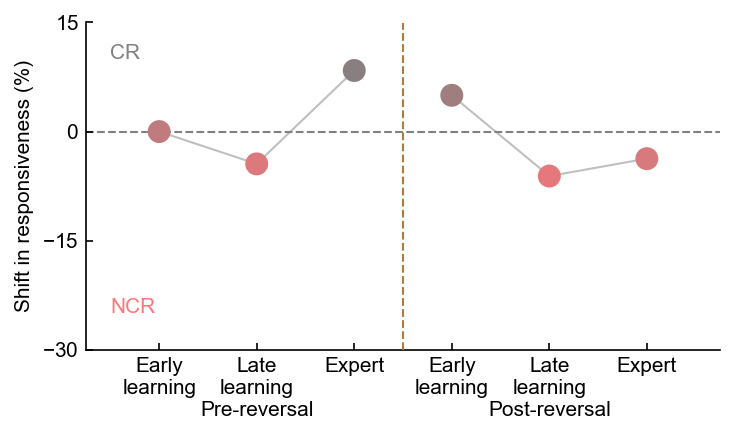

In [17]:
fig, ax = plt.subplots(figsize=(5,3))
percentCR = np.array([FRmod_preearly_pc,FRmod_preint_pc,FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
#percentCR = np.array([FRmod_prelate_pc,FRmod_postearly_pc,FRmod_postint_pc,FRmod_postlate_pc])*100
#labels = ['Pre Late','Early','Intermediate\npost-reversal','Late']
numCon = len(labels)
ax.plot([0,1,2],(percentCR[0:3]-50),color='grey',lw=1,alpha=0.5)
ax.plot([3,4,5],(percentCR[3:6]-50),color='grey',lw=1,alpha=0.5)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),c=color,s=100,zorder=10)

xlims = [-0.75,numCon-0.25]
ax.plot(xlims,[0,0],c='grey',linestyle='--',lw=1,zorder=-10)
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-35,25])
# ax.set_yticks([-30,-20,-10,0,10,20])
# ax.text(-0.5,20,'NCR',color=NCR_COLOR)
# ax.text(-0.5,-30,'CR',color=CR_COLOR)

#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-35,65])
#ax.set_yticks([-30,-15,0,15,30,45,60])
#ax.text(-0.5,55,'NCR',color=NCR_COLOR)
#ax.text(-0.5,-30,'CR',color=CR_COLOR)

#All cells with All Cells baseline
if cellstouseFRmod == 'all cells':
    ax.set_ylabel('Shift in responsiveness (%)')
    ax.set_ylim([-30,15])
    ax.set_yticks([-30,-15,0,15])
    ax.text(-0.5,10,'CR',color=CR_COLOR)
    ax.text(-0.5,-25,'NCR',color=NCR_COLOR)

#Task encoders with All Cells baseline
if cellstouseFRmod == 'task encoders':
    ax.set_ylabel('Shift in responsiveness (%)')
    ax.set_ylim([-15,45])
    ax.set_yticks([-15,0,15,30,45])
    ax.text(-0.5,40,'CR',color=CR_COLOR)
    ax.text(-0.5,-10,'NCR',color=NCR_COLOR)

##Task encoders with All Cells baseline
#ax.set_ylabel('Shift in responsiveness (%)')
#ax.set_ylim([-60,15])
#ax.set_yticks([-60,-45,-30,-15,0,15])
#ax.text(-0.5,10,'CR',color=CR_COLOR)
#ax.text(-0.5,-50,'NCR',color=NCR_COLOR)


#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

plt.tight_layout()

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Shift in responsiveness','AC Shift in responsiveness '+cellstouseFRmod+'.pdf'),transparent=False,facecolor="white")

(0.4161503256210212, 0.20040152034258935, 0.20985037312850605)
(0.5289840830814216, 0.13877779644516375, 0.15586712286718962)
(0.2718337375917164, 0.24849835921096858, 0.2495203465853079)
(0.3223555072573736, 0.23701562858435044, 0.2407531415189354)
(0.5807691126818202, 0.10605300355206071, 0.12684349008329102)
(0.5083824249201088, 0.1511123639864449, 0.1667592279689411)
0
0
0
0
0
0

significance at: 0.01 0.002 0.0002 2e-05
0.25563904257632697
0.04742291522040297
0.11495120846938484
0.20830763215450154
0.2424739677591209
Ttest_indResult(statistic=0.9852555228869997, pvalue=0.32522923691803296)
Ttest_indResult(statistic=-0.04837095792446879, pvalue=0.9614562331844654)
Ttest_indResult(statistic=0.40014558974951314, pvalue=0.6892145672086736)
Ttest_indResult(statistic=1.2890662101832424, pvalue=0.1981530751407631)
Ttest_indResult(statistic=1.2317005429565169, pvalue=0.21878276688435871)


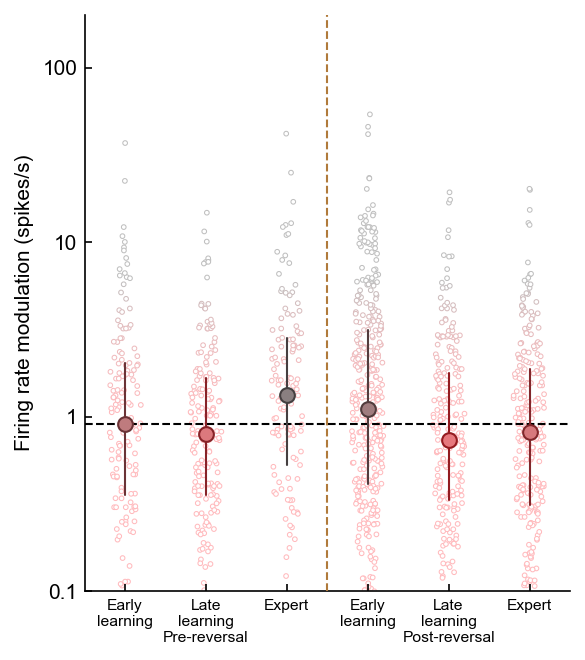

In [18]:
size=5

FRmod_baseline_median = AC_FRmod_baseline_median

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_preint,FRmod_prelate,FRmod_postearly,FRmod_postint,FRmod_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.5)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

ax.set_yscale('log',subsy=[])
#ax.set_ylim([0,10])
ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

pass

plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC FR modulations with shift summary '+cellstouseFRmod+'.pdf'),transparent=False,facecolor="white")

print(np.sum(np.isnan(FRmod_preearly)))
print(np.sum(np.isnan(FRmod_preint)))
print(np.sum(np.isnan(FRmod_prelate)))
print(np.sum(np.isnan(FRmod_postearly)))
print(np.sum(np.isnan(FRmod_postint)))
print(np.sum(np.isnan(FRmod_postlate)))

print('\nsignificance at: ' + str(0.05 / 5)+' '+str(0.01 / 5)+' '+str(0.001 / 5)+' '+str(0.0001 / 5))
print(mannwhitneyu(FRmod_preearly,FRmod_preint).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_prelate).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postearly).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postint).pvalue)
print(mannwhitneyu(FRmod_preearly,FRmod_postlate).pvalue)

print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_preint)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_prelate)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postearly)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postint)))
print(ttest_ind(np.log10(FRmod_preearly),np.log10(FRmod_postlate)))

# All task encoders

In [43]:
pc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre int','pre late','post early','post int','post late']
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    te_in_phase = 0
    cells_in_phase = 0
    for idx in tqdm(range(len(clusters))):
        if not regions[idx] == 'AC':
            continue

        session = sessionIDs[idx]
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if not sessionfile.meta.animal in animalstouse:
            continue

        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
            continue

        if EILphases[idx] != phase:
            continue
            
        cells_in_phase += 1
        if task_encoders[idx]:
            te_in_phase += 1
    
    pc_task_encoders[phase_idx] = np.sum(te_in_phase) / np.sum(cells_in_phase)

100%|██████████| 5801/5801 [00:09<00:00, 594.67it/s] 


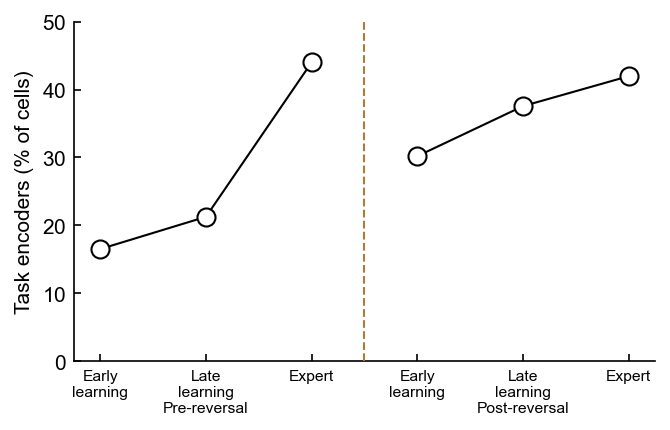

In [44]:
fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color=chosen_color,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color=chosen_color,linestyle='-',zorder=-1,lw=1)
ax.scatter([0,1,2],pc_task_encoders[0:3]*100,fc='white',ec=chosen_color,s=75)
ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Task encoders over learning.pdf'),transparent=False,facecolor="white")

# CR/NCR task encoders

In [45]:
FRmod_baseline_median = AC_FRmod_baseline_median

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre int','pre late','post early','post int','post late']
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    for idx in tqdm(range(len(clusters))):
        if not regions[idx] == 'AC':
            continue

        session = sessionIDs[idx]
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if not sessionfile.meta.animal in animalstouse:
            continue

        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
            continue

        if EILphases[idx] != phase:
            continue
            
        if FRmods[idx] < FRmod_baseline_median:
            if task_encoders[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif FRmods[idx] >= FRmod_baseline_median:
            if task_encoders[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if task_encoders[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

100%|██████████| 5801/5801 [00:09<00:00, 591.07it/s] 


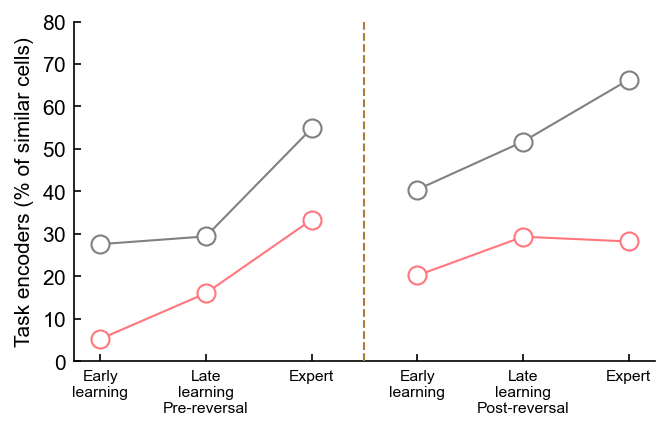

In [152]:
fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_pc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_pc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_pc_task_encoders*100,fc='white',ec=CR_COLOR,s=75)

ax.plot([0,1,2],NCR_pc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_pc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_pc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75)

ax.set_ylim([0,80])
ax.set_ylabel('Task encoders (% of similar cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','CR-NCR similar cells task encoders over learning.pdf'),transparent=False,facecolor="white")

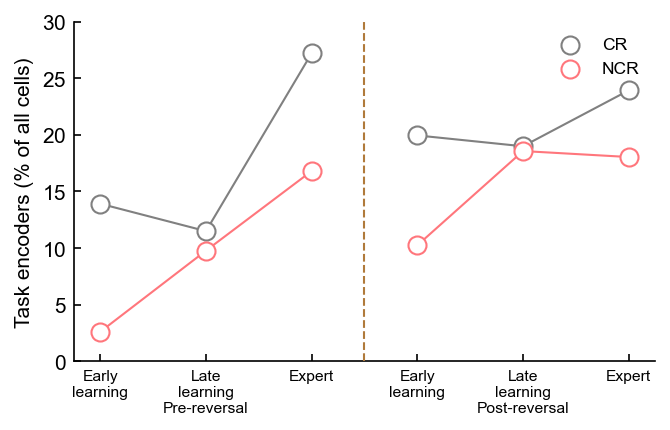

In [153]:
fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

ax.set_ylim([0,30])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.legend(frameon=False)

plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','CR-NCR all cells task encoders over learning.pdf'),transparent=False,facecolor="white")

In [169]:
FRb_preearly = []
FRb_preint = []
FRb_prelate = []
FRb_postearly = []
FRb_postint = []
FRb_postlate = []

FRe_preearly = []
FRe_preint = []
FRe_prelate = []
FRe_postearly = []
FRe_postint = []
FRe_postlate = []

FReT_preearly = []
FReT_preint = []
FReT_prelate = []
FReT_postearly = []
FReT_postint = []
FReT_postlate = []

FReNT_preearly = []
FReNT_preint = []
FReNT_prelate = []
FReNT_postearly = []
FReNT_postint = []
FReNT_postlate = []

FRt_preearly = []
FRt_preint = []
FRt_prelate = []
FRt_postearly = []
FRt_postint = []
FRt_postlate = []

Dec_preearly = []
Dec_preint = []
Dec_prelate = []
Dec_postearly = []
Dec_postint = []
Dec_postlate = []

N = 0

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#cellstouseFR = 'all cells'
cellstouseFR = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if np.isnan(accuracies[idx]):
        continue
        
    N+=1
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        Dec_preearly.append(accuracies[idx])
    elif EILphases[idx] == 'pre int':
        FRb_preint.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preint.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_preint.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preint.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        Dec_preint.append(accuracies[idx])
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        Dec_prelate.append(accuracies[idx])
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        Dec_postearly.append(accuracies[idx])
    elif EILphases[idx] == 'post int':
        FRb_postint.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postint.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postint.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postint.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        Dec_postint.append(accuracies[idx])
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        Dec_postlate.append(accuracies[idx])
        
FRb_preearly = np.array(FRb_preearly)
FRb_preint = np.array(FRb_preint)
FRb_prelate = np.array(FRb_prelate)
FRb_postearly = np.array(FRb_postearly)
FRb_postint = np.array(FRb_postint)
FRb_postlate = np.array(FRb_postlate)

FRe_preearly = np.array(FRe_preearly)
FRe_preint = np.array(FRe_preint)
FRe_prelate = np.array(FRe_prelate)
FRe_postearly = np.array(FRe_postearly)
FRe_postint = np.array(FRe_postint)
FRe_postlate = np.array(FRe_postlate)

FReT_preearly = np.array(FReT_preearly)
FReT_preint = np.array(FReT_preint)
FReT_prelate = np.array(FReT_prelate)
FReT_postearly = np.array(FReT_postearly)
FReT_postint = np.array(FReT_postint)
FReT_postlate = np.array(FReT_postlate)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_preint = np.array(FReNT_preint)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postint = np.array(FReNT_postint)
FReNT_postlate = np.array(FReNT_postlate)

FRt_preearly = np.array(FRt_preearly)
FRt_preint = np.array(FRt_preint)
FRt_prelate = np.array(FRt_prelate)
FRt_postearly = np.array(FRt_postearly)
FRt_postint = np.array(FRt_postint)
FRt_postlate = np.array(FRt_postlate)

Dec_preearly = np.array(Dec_preearly)
Dec_preint = np.array(Dec_preint)
Dec_prelate = np.array(Dec_prelate)
Dec_postearly = np.array(Dec_postearly)
Dec_postint = np.array(Dec_postint)
Dec_postlate = np.array(Dec_postlate)

print('spontaneous '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRb_preearly,FRb_preint).pvalue)
print(mannwhitneyu(FRb_preearly,FRb_prelate).pvalue)
print(mannwhitneyu(FRb_postearly,FRb_postint).pvalue)
print(mannwhitneyu(FRb_postearly,FRb_postlate).pvalue)

print()
print('evoked: '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRe_preearly,FRe_preint).pvalue)
print(mannwhitneyu(FRe_preearly,FRe_prelate).pvalue)
print(mannwhitneyu(FRe_postearly,FRe_postint).pvalue)
print(mannwhitneyu(FRe_postearly,FRe_postlate).pvalue)

print()
print('tuning '+str(0.05/4)+' '+str(0.01/4)+' '+str(0.001/4)+' '+str(0.0001/4))
print(mannwhitneyu(FRt_preearly,FRt_preint).pvalue)
print(mannwhitneyu(FRt_preearly,FRt_prelate).pvalue)
print(mannwhitneyu(FRt_postearly,FRt_postint).pvalue)
print(mannwhitneyu(FRt_postearly,FRt_postlate).pvalue)

5801it [00:04, 1362.18it/s]

spontaneous 0.0125 0.0025 0.00025 2.5e-05
0.4688292988409108
0.4422619260806449
0.1248566881473846
0.014147689402155276

evoked: 0.0125 0.0025 0.00025 2.5e-05
0.012030773244899776
0.016042735359308575
0.0017516779075590423
0.014263312607480436

tuning 0.0125 0.0025 0.00025 2.5e-05
0.19813252146510235
0.051254000914680645
0.020450085338394604
3.0045116269897087e-06


In [719]:
print('Spontaneous Significances: p < '+str(0.05/7))
print('pre-early,pre-late     :'+str(mannwhitneyu(FRb_preearly,FRb_preint).pvalue))
print('pre-early,pre-expert   :'+str(mannwhitneyu(FRb_preearly,FRb_prelate).pvalue))
print('pre-late,pre-expert    :'+str(mannwhitneyu(FRb_preint,FRb_prelate).pvalue))
print('pre-expert,post-early  :'+str(mannwhitneyu(FRb_prelate,FRb_postearly).pvalue))
print('post-early,post-late   :'+str(mannwhitneyu(FRb_postearly,FRb_postint).pvalue))
print('post-early,post-expert :'+str(mannwhitneyu(FRb_postearly,FRb_postlate).pvalue))
print('post-late,post-expert  :'+str(mannwhitneyu(FRb_postlate,FRb_postlate).pvalue))

print()
print('Evoked Significances: p < '+str(0.05/7))
print('pre-early,pre-late     :'+str(mannwhitneyu(FRe_preearly,FRe_preint).pvalue))
print('pre-early,pre-expert   :'+str(mannwhitneyu(FRe_preearly,FRe_prelate).pvalue))
print('pre-late,pre-expert    :'+str(mannwhitneyu(FRe_preint,FRe_prelate).pvalue))
print('pre-expert,post-early  :'+str(mannwhitneyu(FRe_prelate,FRe_postearly).pvalue))
print('post-early,post-late   :'+str(mannwhitneyu(FRe_postearly,FRe_postint).pvalue))
print('post-early,post-expert :'+str(mannwhitneyu(FRe_postearly,FRe_postlate).pvalue))
print('post-late,post-expert  :'+str(mannwhitneyu(FRe_postlate,FRe_postlate).pvalue))

Spontaneous Significances: p < 0.0071428571428571435
pre-early,pre-late     :0.13769219259584892
pre-early,pre-expert   :0.411636830104011
pre-late,pre-expert    :0.19105257764562494
pre-expert,post-early  :0.08013717494529199
post-early,post-late   :0.1534898960388748
post-early,post-expert :0.056685153844663036
post-late,post-expert  :0.4998801266725263

Evoked Significances: p < 0.0071428571428571435
pre-early,pre-late     :0.002041026459247018
pre-early,pre-expert   :0.19545008064044017
pre-late,pre-expert    :0.02490231331909759
pre-expert,post-early  :0.3908601489632584
post-early,post-late   :0.006545481298723171
post-early,post-expert :0.009333292768164678
post-late,post-expert  :0.4998801265857721


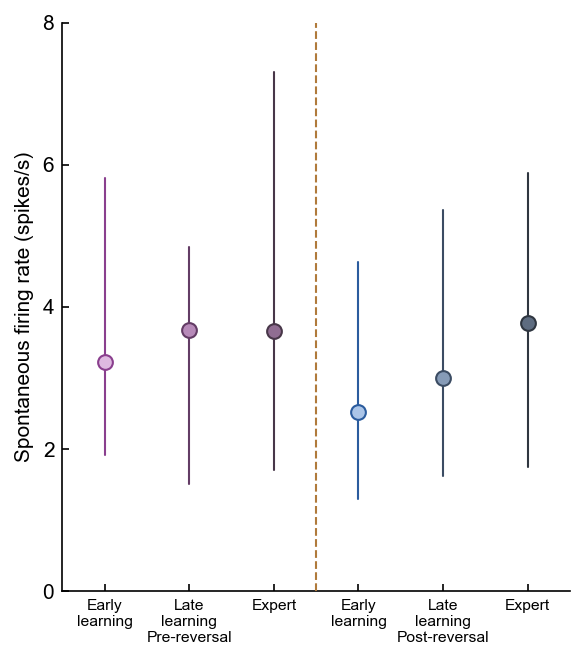

In [170]:
size=5

FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRb_preearly,FRb_preint,FRb_prelate,FRb_postearly,FRb_postint,FRb_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_ylabel('Spontaneous firing rate (spikes/s)')

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,8])
ax.set_yticks([0,2,4,6,8])
#ax.set_yticklabels(['1','10'])
ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRb_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Spontaneous FR '+cellstouseFR+'.pdf'),transparent=False,facecolor="white")

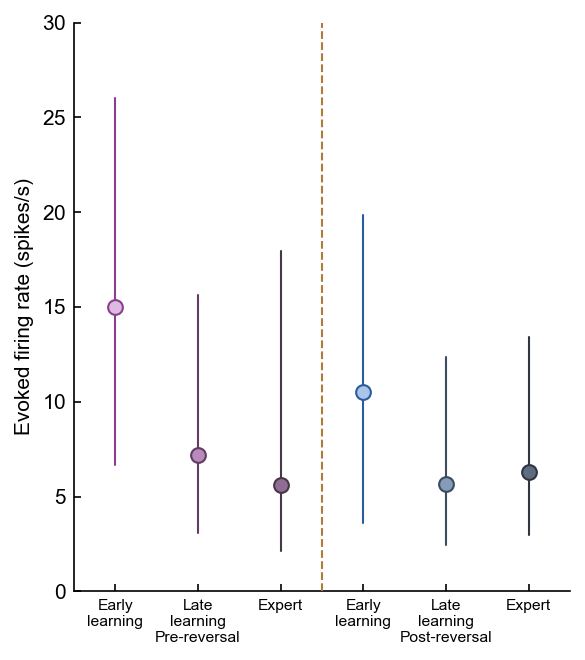

In [171]:
size=5

FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRe_preearly,FRe_preint,FRe_prelate,FRe_postearly,FRe_postint,FRe_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X, Y, s=size, ec=GOOD_GREY, fc='white', lw=0.5,zorder=-10)

#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
    
#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_ylabel('Spontaneous firing rate (spikes/s)')

#ax.set_yscale('log',subsy=[])
if cellstouseFRmod == 'all cells':
    ax.set_ylim([1,20])
    ax.set_yticks([0,5,10,15,20])
    ax.set_ylabel('Evoked firing rate (spikes/s)')
elif cellstouseFRmod == 'task encoders':
    ax.set_ylim([1,30])
    ax.set_yticks([0,5,10,15,20,25,30])
    ax.set_ylabel('Evoked firing rate (spikes/s)')
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRb_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Evoked FR '+cellstouseFR+'.pdf'),transparent=False,facecolor="white")

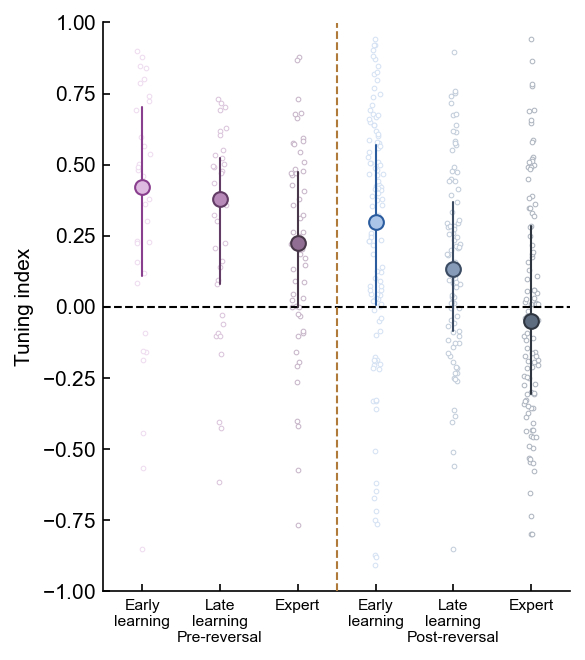

In [172]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRt_preearly,FRt_preint,FRt_prelate,-FRt_postearly,-FRt_postint,-FRt_postlate]
labels = ['Early\nlearning','Late\nlearning\nPre-reversal','Expert','Early\nlearning','Late\nlearning\nPost-reversal','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])

ax.scatter(X[unitsperphase[0]:unitsperphase[1]], Y[unitsperphase[0]:unitsperphase[1]], s=size, ec=phase_colors[0], fc='white', lw=0.5,zorder=-10)
ax.scatter(X[unitsperphase[1]:unitsperphase[2]], Y[unitsperphase[1]:unitsperphase[2]], s=size, ec=phase_colors[1], fc='white', lw=0.5,zorder=-10)
ax.scatter(X[unitsperphase[2]:unitsperphase[3]], Y[unitsperphase[2]:unitsperphase[3]], s=size, ec=phase_colors[2], fc='white', lw=0.5,zorder=-10)
ax.scatter(X[unitsperphase[3]:unitsperphase[4]], Y[unitsperphase[3]:unitsperphase[4]], s=size, ec=phase_colors[3], fc='white', lw=0.5,zorder=-10)
ax.scatter(X[unitsperphase[4]:unitsperphase[5]], Y[unitsperphase[4]:unitsperphase[5]], s=size, ec=phase_colors[4], fc='white', lw=0.5,zorder=-10)
ax.scatter(X[unitsperphase[5]:unitsperphase[6]], Y[unitsperphase[5]:unitsperphase[6]], s=size, ec=phase_colors[5], fc='white', lw=0.5,zorder=-10)


#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    #Q1 = median - np.nanstd(column)
    #Q3 = median + np.nanstd(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([-1,1])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Tuning index')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels,fontsize=7.5)
ax.set_xlim(ax.get_xlim())

ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
ax.axhline(0,color='k',linestyle='--',lw=1,zorder=-4)

pass

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Tuning '+cellstouseFR+'.pdf'),transparent=False,facecolor="white")

In [144]:
print(np.sum(np.isfinite(FRt_preearly)))

146


In [34]:
valid_acc = []
is_TE = []

animalstouse = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

cellstouseTE = 'all cells'
#cellstouseTE = 'task encoders'

for idx,clust in tqdm(enumerate(clusters)):
    if not regions[idx] == 'AC':
        continue
    
    if cellstouseTE == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    session = sessionIDs[idx]
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not sessionfile.meta.animal in animalstouse:
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    valid_acc.append(accuracies[idx])
    if task_encoders[idx]:
        is_TE.append(True)
    else:
        is_TE.append(False)

5801it [00:09, 588.75it/s] 


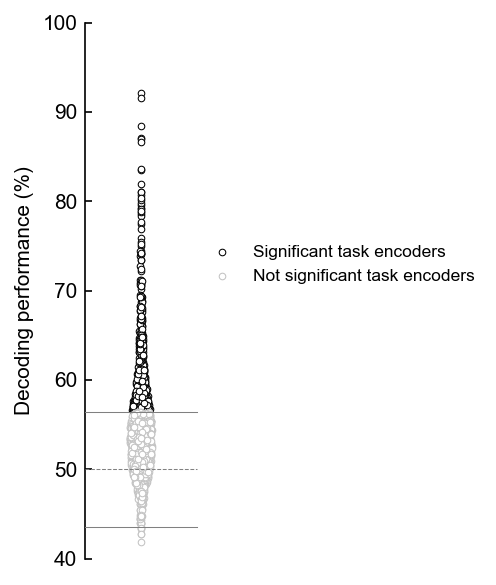

In [157]:
fig, ax = plt.subplots(figsize=(3,4))



X = np.ones_like(valid_acc)
_,Y = ilep.violin(X,valid_acc)
X,_ = ilep.violin(X,np.log10(valid_acc),width=0.25)

size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=0,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])

ax.axhline(task_encoder_threshold,linestyle='-',color='grey',zorder=10,lw=0.5,xmax=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=10,lw=0.5,xmax=0.5)
ax.axhline(0.5-(task_encoder_threshold-0.5),linestyle='-',color='grey',zorder=10,lw=0.5,xmax=0.5)

ax.legend(frameon=False,loc=(0.5,0.5))

ax.set_ylabel('Decoding performance (%)')
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Task encoders schematic.pdf'),transparent=False,facecolor="white")

In [57]:
FRmodData = SimpleNamespace()
FRmodData.prereversal_early = FRmod_preearly
FRmodData.prereversal_late = FRmod_preint
FRmodData.prereversal_expert = FRmod_prelate
FRmodData.postreversal_early = FRmod_postearly
FRmodData.postreversal_late = FRmod_postint
FRmodData.postreversal_expert = FRmod_postlate

filename = 'C:\\Users\\insan\\Desktop\\FRmodDataForStats.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FRmodData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
FReData = SimpleNamespace()
FReData.prereversal_early = FRe_preearly
FReData.prereversal_late = FRe_preint
FReData.prereversal_expert = FRe_prelate
FReData.postreversal_early = FRe_postearly
FReData.postreversal_late = FRe_postint
FReData.postreversal_expert = FRe_postlate

filename = 'C:\\Users\\insan\\Desktop\\FReDataForStats.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FReData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
FRbData = SimpleNamespace()
FRbData.prereversal_early = FRmod_preearly
FRbData.prereversal_late = FRmod_preint
FRbData.prereversal_expert = FRb_prelate
FRbData.postreversal_early = FRb_postearly
FRbData.postreversal_late = FRb_postint
FRbData.postreversal_expert = FRb_postlate

filename = 'C:\\Users\\insan\\Desktop\\FRbDataForStats.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FRbData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
FRtData = SimpleNamespace()
FRtData.prereversal_early = FRt_preearly
FRtData.prereversal_late = FRt_preint
FRtData.prereversal_expert = FRt_prelate
FRtData.postreversal_early = FRt_postearly
FRtData.postreversal_late = FRt_postint
FRtData.postreversal_expert = FRt_postlate

filename = 'C:\\Users\\insan\\Desktop\\FRtDataForStats.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FRtData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
#ENSURE TASK ENCODERS ARE SELECTED

FRmodteData = SimpleNamespace()
FRmodteData.prereversal_early = FRmod_preearly
FRmodteData.prereversal_late = FRmod_preint
FRmodteData.prereversal_expert = FRmod_prelate
FRmodteData.postreversal_early = FRmod_postearly
FRmodteData.postreversal_late = FRmod_postint
FRmodteData.postreversal_expert = FRmod_postlate

filename = 'C:\\Users\\insan\\Desktop\\FRmodteDataForStats.pickle'

with open(filename, 'wb') as f:
    pickle.dump(FRmodteData, f, protocol=pickle.HIGHEST_PROTOCOL)

In [175]:
print(np.sum(np.isfinite(FRmod_preearly)))
print(np.sum(np.isfinite(FRmod_preint)))
print(np.sum(np.isfinite(FRmod_prelate)))
print(np.sum(np.isfinite(FRmod_switch)))
print(np.sum(np.isfinite(FRmod_postearly)))
print(np.sum(np.isfinite(FRmod_postint)))
print(np.sum(np.isfinite(FRmod_postlate)))

148
180
125
124
371
237
255


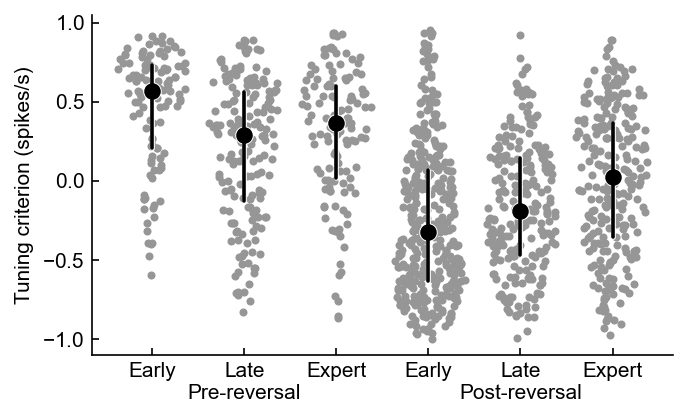

In [103]:
size=15

fig, ax = plt.subplots(figsize=(5,3))
data = [FRt_preearly,FRt_preint,FRt_prelate,FRt_postearly,FRt_postint,FRt_postlate]
labels = ['Early','Late\nPre-reversal','Expert','Early','Late\nPost-reversal','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data))
#X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)))
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, c=GOOD_GREY, lw=0)

#Plot summary
for idx,column in enumerate(data):
    summary_color='k'
    summary_size=12
    median_scale = 4
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    ax.scatter([idx], [median], c='w', s=summary_size*1.3*median_scale, zorder=5)
    ax.scatter([idx], [median], c=summary_color, s=summary_size*median_scale, zorder=7)
    #ax.scatter([idx], [median], c=GOOD_GREY, s=summary_size*median_scale*0.5, zorder=8)
    ax.plot([idx, idx], [Q1, Q3], c='w', lw=np.sqrt(summary_size) * .5 * 1.3, zorder=5, solid_capstyle='round')
    ax.plot([idx, idx], [Q1, Q3], c=summary_color, lw=np.sqrt(summary_size)*.5, zorder=6, solid_capstyle='round')

#ax.scatter([],[], s=50, c=CR_COLOR, zorder=0, lw=0, label='CRs')
#ax.scatter([],[], s=50, c=NCR_COLOR, zorder=0, lw=0, label='NCRs')
#ax.legend(frameon=False)

#ax.set_yscale('log',subsy=[])
#ax.set_ylim([0.1,200])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Tuning criterion (spikes/s)')

ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
pass

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','FR modulations','AC Tuning '+cellstouse+'.pdf'),transparent=False,facecolor="white")

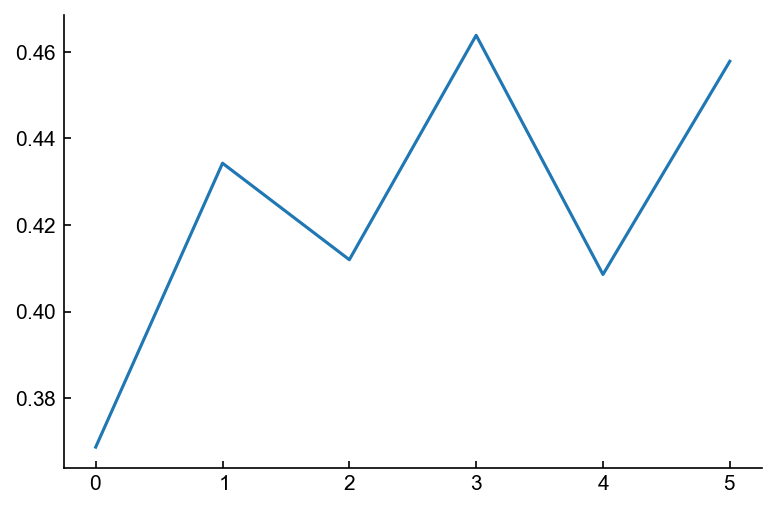

In [96]:
plt.plot([np.std(d) for d in data])


In [134]:
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.day_of_training > 3:
        continue
        
    print(ilep.generateDateString(sessionfile) + ' day  ' +str(sessionfile.meta.day_of_training))

 40%|███▉      | 158/398 [00:01<00:02, 107.14it/s]

BS_49_1_AC_8-31-2021 day  1
BS_49_2_AC_9-1-2021 day  2
BS_50_2_AC_9-9-2021 day  2
BS_50_3_AC_9-10-2021 day  3


 68%|██████▊   | 270/398 [00:02<00:01, 116.03it/s]

BS_78_1_AC_12-9-2021 day  1
BS_78_2_AC_12-10-2021 day  2
BS_78_3_AC_12-13-2021 day  3


100%|██████████| 398/398 [00:04<00:00, 85.10it/s] 
